In [1]:
#import libraries
import numpy as np
import cv2
from scipy import signal
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
#implemneting lucas kanade algorithm
def lucas_kanade(I1g, I2g, window_size):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = sm_ig1/255.
    I2g = sm_ig2/255.
    #Implement Lucas Kanade
    #for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) +\
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    for i in range(w, I1g.shape[0] - w):
        for j in range(w, I1g.shape[1] - w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            At_A = np.array(([np.sum(np.multiply(Ix, Ix)), np.sum(np.multiply(Ix, Iy))], [np.sum(np.multiply(Ix, Iy)), np.sum(np.multiply(Iy, Iy))]))
            At_b = np.array([-np.sum(np.multiply(Ix, It)), -np.sum(np.multiply(Iy, It))])
            nu = np.linalg.lstsq(At_A, At_b)[0]
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            u[i,j]=nu[0]
            v[i,j]=nu[1]
    return u,v


In [3]:
#thresholding to get layers
def thresholding(image,threshold1, threshold2, threshold3, threshold4, threshold5):
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] <= threshold1:
                output[i][j] = 0
            elif (image[i][j] <= threshold2) and (image[i][j] > threshold1):
                output[i][j] = 50
            elif (image[i][j] <= threshold3) and (image[i][j] > threshold2):
                output[i][j] = 100
            elif (image[i][j] <= threshold4) and (image[i][j] > threshold3):
                output[i][j] = 150
            elif (image[i][j] <= threshold5) and (image[i][j] > threshold4):
                output[i][j] = 200
            else:
                output[i][j] = 255
    return output

In [4]:
def displayflow(Image, u, v, Divisor):
    "Display image with a visualisation of a flow over the top. A divisor controls the density of the quiver plot."
    PictureShape = np.shape(Image)
    #determine number of quiver points there will be
    Imax = int(PictureShape[0]/Divisor)
    Jmax = int(PictureShape[1]/Divisor)
    #create a blank mask, on which lines will be drawn.
    mask = np.zeros_like(Image)
    for i in range(1, Imax):
        for j in range(1, Jmax):
            X1 = (i)*Divisor
            Y1 = (j)*Divisor
            X2 = int(X1 + v[X1,Y1])
            Y2 = int(Y1 + u[X1,Y1])
            X2 = np.clip(X2, 0, PictureShape[0])
            Y2 = np.clip(Y2, 0, PictureShape[1])
            #add all the lines to the mask
            mask = cv2.arrowedLine(mask, (Y1,X1),(Y2,X2), [255,255,255], 2)
    #superpose lines onto image
    img = cv2.add(Image,mask)
    #print image
    plt.figure(figsize=(10,10))
    pla = plt.imshow(img, cmap = 'gray')
    return img,pla

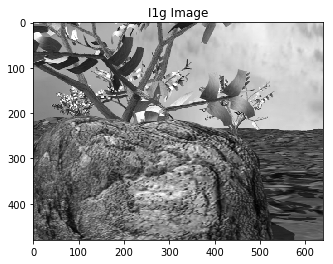

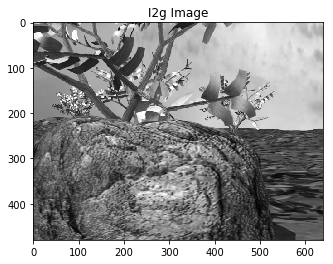

In [5]:
#read and display two frames 
I1g = cv2.imread('C:/Users/reemasinghal/Downloads/im1-syn0.png',0)

plt.imshow(I1g, cmap = 'gray')
plt.title('I1g Image')
plt.show()

I2g = cv2.imread('C:/Users/reemasinghal/Downloads/im1-syn1.png',0)

plt.imshow(I2g, cmap = 'gray')
plt.title('I2g Image')
plt.show()

In [6]:
#gaussian filter
sm_ig1 = cv2.GaussianBlur(I1g, (7,7), 0)
sm_ig2 = cv2.GaussianBlur(I2g, (7,7), 0)

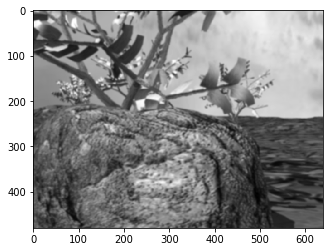

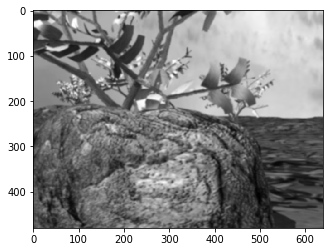

In [7]:
plt.imshow(sm_ig1, cmap = 'gray')
plt.show()

plt.imshow(sm_ig2, cmap = 'gray')
plt.show()

In [8]:
u,v = lucas_kanade(sm_ig1, sm_ig2, 4)

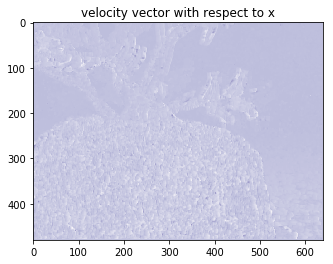

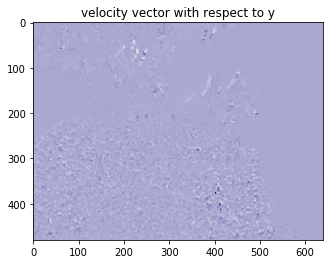

In [9]:
#representing velocity vectors
plt.imshow(u, cmap='Purples')
plt.title('velocity vector with respect to x')
plt.show()

scaled_u = (((u - u.min())/(u.max() - u.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/x_velocityvector.png", scaled_u, cmap = 'Purples') 

plt.imshow(v, cmap='Purples')
plt.title('velocity vector with respect to y')
plt.show()
scaled_v = (((v - v.min())/(v.max() - v.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/y_velocityvector.png", scaled_v, cmap = 'Purples')

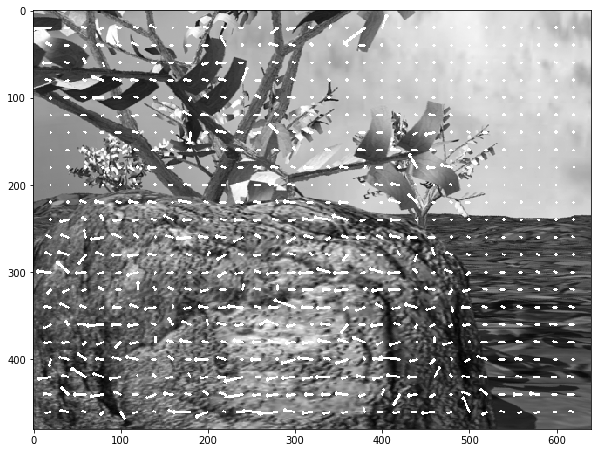

In [10]:
array, opt_flow_image = displayflow(I1g,u*2,v,20)
#opt_flow_image = np.array(opt_flow_image)
plt.show(opt_flow_image)

plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/optical_flow_image.png", array, cmap = 'gray')

In [11]:
#normalize velocity vector in x direction
ut = u - u.min()
u1 = np.divide(ut, ut.max())

#testing:to get threshold values by taking average of intensities in a particular area 
u1t = np.mean(u1[300:400, 100:200])
print u1t

u2t = np.mean(u1[0:100, 570:600])
print u2t

u3t = np.mean(u1[400:450, 600:640])
print u3t

u4t = np.mean(u1[135:145, 310:320])
print u4t

0.322283533972
0.365968993211
0.327820730957
0.355212576927


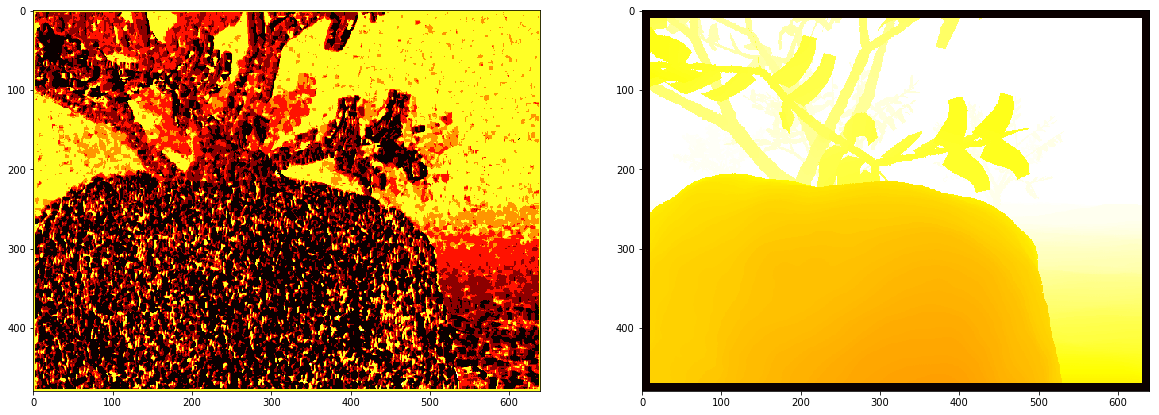

In [12]:
#based on the values we get in testing the threshold, we set the corresponding values 

thru = thresholding(u1, 0.3228, 0.341, 0.3562, 0.362, 0.5 )

plt.figure(figsize=(20,40))

plt.subplot(121)
plt.imshow(thru, cmap = 'hot')
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/threshold_image.png", thru, cmap = 'hot')
'''
we load the ground truth image to compare the image we get after thresholding and the ground truth image
'''
gt = cv2.imread('C:/Users/reemasinghal/Downloads/gt-syn.png',0)

plt.subplot(122)
plt.imshow(gt, cmap='hot')
plt.show()
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/groundtruth.png", gt,cmap = 'hot')

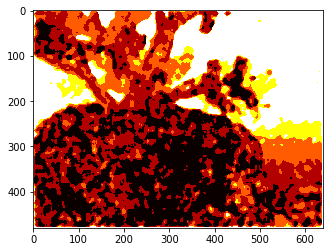

In [13]:
#we apply median filtering to remove salt and pepper noise
thru = thru.astype(np.uint8)
sp_u = cv2.medianBlur(thru,11)


plt.imshow(sp_u, cmap = 'hot')
plt.show()
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/meadian_filtered_image.png", sp_u, cmap = 'hot')

# New Image

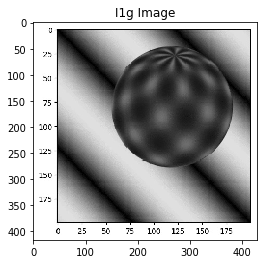

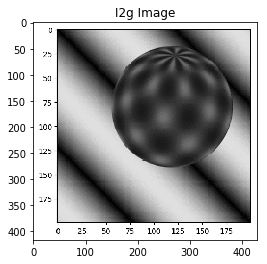

In [14]:
#read and display two frames 
I1g = cv2.imread('C:/Users/reemasinghal/Downloads/data/data/frame2.jpg',0)

plt.imshow(I1g, cmap = 'gray')
plt.title('I1g Image')
plt.show()

I2g = cv2.imread('C:/Users/reemasinghal/Downloads/data/data/frame3.jpg',0)

plt.imshow(I2g, cmap = 'gray')
plt.title('I2g Image')
plt.show()

In [15]:
#gaussian filter
sm_ig1 = cv2.GaussianBlur(I1g, (7,7), 0)
sm_ig2 = cv2.GaussianBlur(I2g, (7,7), 0)

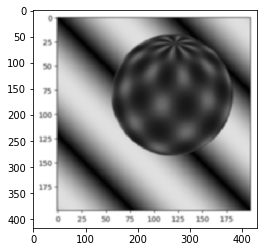

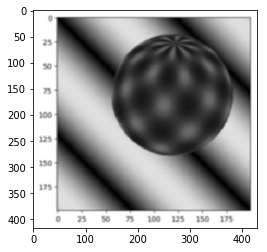

In [16]:
plt.imshow(sm_ig1, cmap = 'gray')
plt.show()

plt.imshow(sm_ig2, cmap = 'gray')
plt.show()

In [17]:
u,v = lucas_kanade(sm_ig1, sm_ig2, 4)

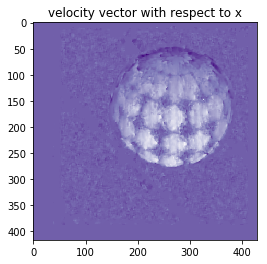

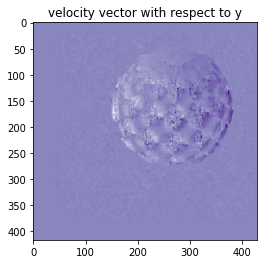

In [18]:
#representing velocity vectors
plt.imshow(u, cmap='Purples')
plt.title('velocity vector with respect to x')
plt.show()

scaled_u = (((u - u.min())/(u.max() - u.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/x_velocityvector2.png", scaled_u, cmap = 'Purples') 

plt.imshow(v, cmap='Purples')
plt.title('velocity vector with respect to y')
plt.show()
scaled_v = (((v - v.min())/(v.max() - v.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/y_velocityvector2.png", scaled_v, cmap = 'Purples')

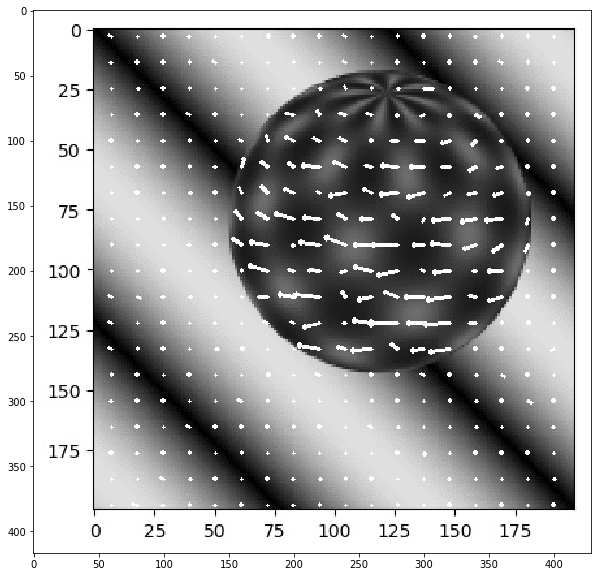

In [19]:
array, opt_flow_image = displayflow(I1g,u*2,v,20)
#opt_flow_image = np.array(opt_flow_image)
plt.show(opt_flow_image)

plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/optical_flow_image2.png", array, cmap = 'gray')

In [20]:
#normalize velocity vector in x direction
ut = u - u.min()
u1 = np.divide(ut, ut.max())

#testing:to get threshold values by taking average of intensities in a particular area 
u1t = np.mean(u1[220:230, 210:220])
print(u1t) 

u2t = np.mean(u1[150, 280])
print(u2t)

u3t = np.mean(u1[55, 160])
print(u3t)

u3t = np.mean(u1[60, 210])
print(u3t)

0.279683018778
0.504775678993
0.710557390868
0.679826851834


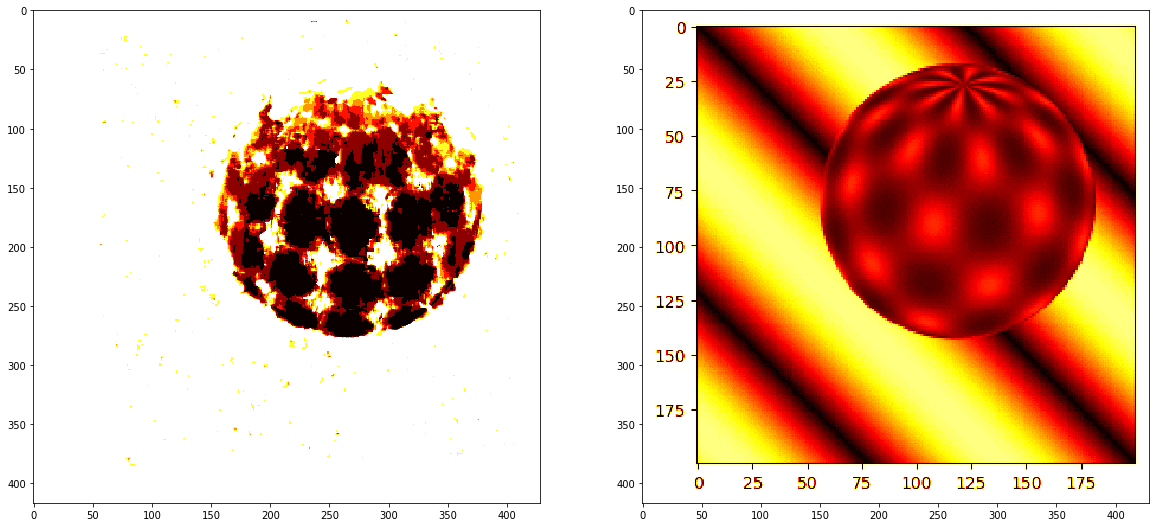

In [21]:
#based on the values we get in testing the threshold, we set the corresponding values 

thru = thresholding(u1, 0.48, 0.58, 0.61, 0.635, 0.66 )

plt.figure(figsize=(20,40))

plt.subplot(121)
plt.imshow(thru, cmap = 'hot')
'''
we load the ground truth image to compare the image we get after thresholding and the ground truth image
'''
gt = cv2.imread('C:/Users/reemasinghal/Downloads/data/data/frame2.jpg',0)

plt.subplot(122)
plt.imshow(gt, cmap='hot')
plt.show()
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/fireball1.png', thru, cmap='hot')
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/groundtruth1.png', gt, cmap='hot')

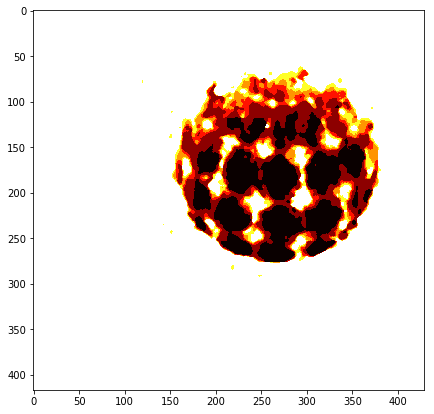

In [22]:
#we apply median filtering to remove salt and pepper noise
thru = thru.astype(np.uint8)
sp_u = cv2.medianBlur(thru,5)

plt.figure(figsize=(7,7))
plt.imshow(sp_u, cmap = 'hot')
plt.show()
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/meadian_filtered_image1.png", sp_u, cmap = 'hot')

# New Image

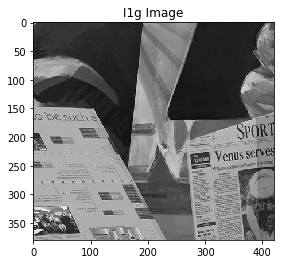

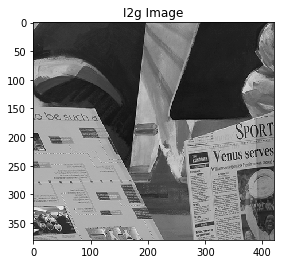

In [23]:
#read and display two frames 
I1g = cv2.imread('C:/Users/reemasinghal/Downloads/im0-2.png',0)

plt.imshow(I1g, cmap = 'gray')
plt.title('I1g Image')
plt.show()

I2g = cv2.imread('C:/Users/reemasinghal/Downloads/2im1-2.png',0)

plt.imshow(I2g, cmap = 'gray')
plt.title('I2g Image')
plt.show()

In [24]:
#gaussian filter
sm_ig1 = cv2.GaussianBlur(I1g, (13,13), 0)
sm_ig2 = cv2.GaussianBlur(I2g, (13,13), 0)

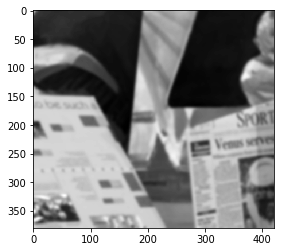

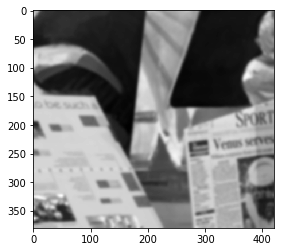

In [25]:
plt.imshow(sm_ig1, cmap = 'gray')
plt.show()

plt.imshow(sm_ig2, cmap = 'gray')
plt.show()

In [26]:
u,v = lucas_kanade(sm_ig1, sm_ig2, 4)

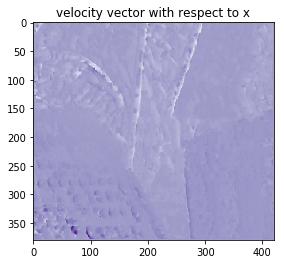

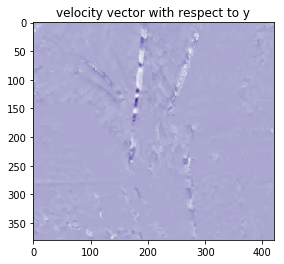

In [27]:
#representing velocity vectors
plt.imshow(u, cmap='Purples')
plt.title('velocity vector with respect to x')
plt.show()

scaled_u = (((u - u.min())/(u.max() - u.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/x_velocityvector3.png", scaled_u, cmap = 'Purples') 

plt.imshow(v, cmap='Purples')
plt.title('velocity vector with respect to y')
plt.show()
scaled_v = (((v - v.min())/(v.max() - v.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/y_velocityvector3.png", scaled_v, cmap = 'Purples')

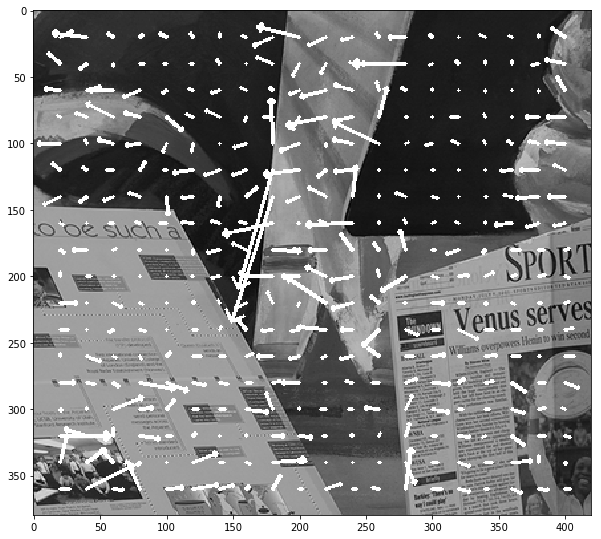

In [28]:
array, opt_flow_image = displayflow(I1g,u*2,v,20)
#opt_flow_image = np.array(opt_flow_image)
plt.show(opt_flow_image)

plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/optical_flow_image3.png", array, cmap = 'gray')

In [29]:
#normalize velocity vector in x direction
ut = u - u.min()
u1 = np.divide(ut, ut.max())

#testing:to get threshold values by taking average of intensities in a particular area 
u1t = np.mean(u1[30,160])
print(u1t) 

u2t = np.mean(u1[170,110])
print(u2t)

u3t = np.mean(u1[220, 290])
print(u3t)

u3t = np.mean(u1[20:210])
print(u3t)

0.486534758881
0.478787343225
0.517162090692
0.473408293315


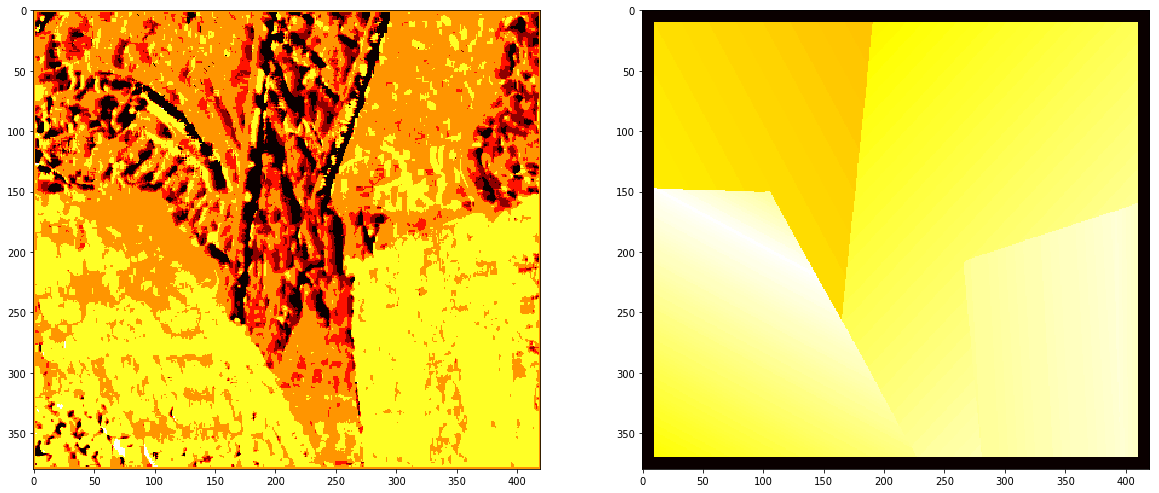

In [30]:
#based on the values we get in testing the threshold, we set the corresponding values 

thru = thresholding(u1, 0.44, 0.456, 0.47, 0.495, 0.7)

plt.figure(figsize=(20,40))

plt.subplot(121)
plt.imshow(thru, cmap = 'hot')
'''
we load the ground truth image to compare the image we get after thresholding and the ground truth image
'''
gt = cv2.imread('C:/Users/reemasinghal/Downloads/gt-2.png',0)

plt.subplot(122)
plt.imshow(gt, cmap='hot')
plt.show()
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/paper.png', thru, cmap='hot')
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/groundtruth3.png', gt, cmap='hot')

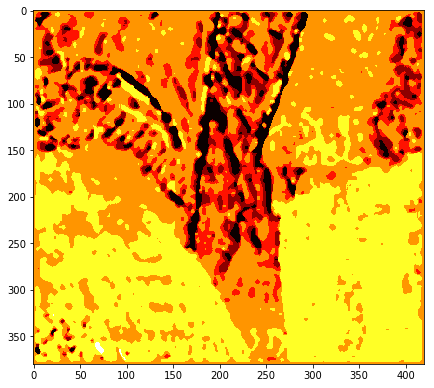

In [31]:
#we apply median filtering to remove salt and pepper noise
thru = thru.astype(np.uint8)
sp_u = cv2.medianBlur(thru,5)

plt.figure(figsize=(7,7))
plt.imshow(sp_u, cmap = 'hot')
plt.show()
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/meadian_filtered_image2.png", sp_u, cmap = 'hot')

# New Image

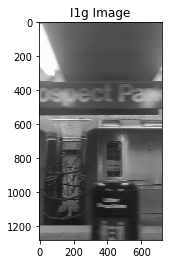

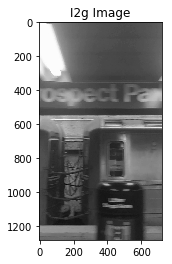

In [32]:
#read and display two frames 
I1g = cv2.imread('C:/Users/reemasinghal/Downloads/frame522.jpg',0)

plt.imshow(I1g, cmap = 'gray')
plt.title('I1g Image')
plt.show()

I2g = cv2.imread('C:/Users/reemasinghal/Downloads/frame523.jpg',0)

plt.imshow(I2g, cmap = 'gray')
plt.title('I2g Image')
plt.show()

In [33]:
I1g= cv2.resize(I1g, (200,355))
I2g= cv2.resize(I2g, (200,355))

In [34]:
#gaussian filter
sm_ig1 = cv2.GaussianBlur(I1g, (7,7), 0)
sm_ig2 = cv2.GaussianBlur(I2g, (7,7), 0)

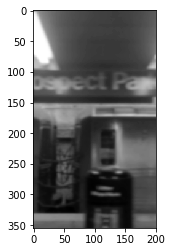

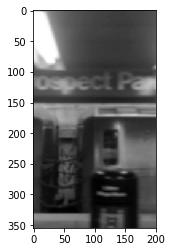

In [35]:
plt.imshow(sm_ig1, cmap = 'gray')
plt.show()

plt.imshow(sm_ig2, cmap = 'gray')
plt.show()

In [36]:
u,v = lucas_kanade(sm_ig1, sm_ig2, 8)

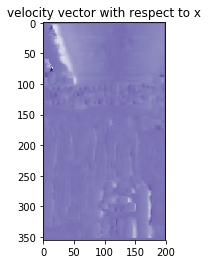

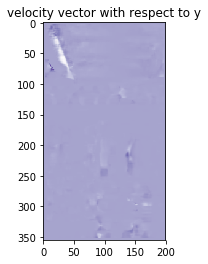

In [37]:
#representing velocity vectors
plt.imshow(u, cmap='Purples')
plt.title('velocity vector with respect to x')
plt.show()

scaled_u = (((u - u.min())/(u.max() - u.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/x_velocityvector4.png", scaled_u, cmap = 'Purples') 

plt.imshow(v, cmap='Purples')
plt.title('velocity vector with respect to y')
plt.show()
scaled_v = (((v - v.min())/(v.max() - v.min()))*255)
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/y_velocityvector4.png", scaled_v, cmap = 'Purples')

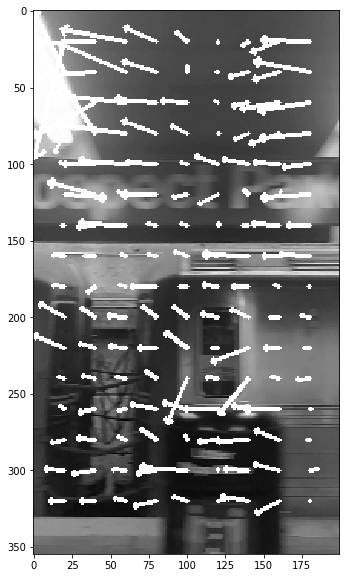

In [38]:
array, opt_flow_image = displayflow(I1g,u*2,v,20)
#opt_flow_image = np.array(opt_flow_image)
plt.show(opt_flow_image)

plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/optical_flow_image4.png", array, cmap = 'gray')

In [39]:
#normalize velocity vector in x direction
ut = u - u.min()
u1 = np.divide(ut, ut.max())

#testing:to get threshold values by taking average of intensities in a particular area 
u1t = np.mean(u1[335:345, 145:155])
print(u1t) 

u2t = np.mean(u1[130, 5])
print(u2t)

u3t = np.mean(u1[200, 20])
print(u3t)

u3t = np.mean(u1[225, 50])
print(u3t)

0.492349479869
0.615245485112
0.620515085969
0.630995286937


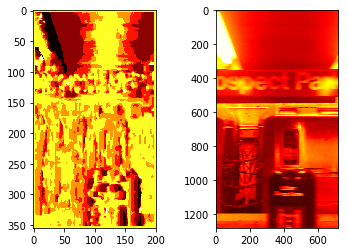

In [40]:
#based on the values we get in testing the threshold, we set the corresponding values 

thru = thresholding(u1, 0.49, 0.6, 0.625, 0.64, 0.7)

#plt.figure(figsize=(4,30))

plt.subplot(121)
plt.imshow(thru, cmap = 'hot')
'''
we load the ground truth image to compare the image we get after thresholding and the ground truth image
'''
gt = cv2.imread('C:/Users/reemasinghal/Downloads/frame522.jpg',0)

plt.subplot(122)
plt.imshow(gt, cmap='hot')
plt.show()
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/trainrun.png', thru, cmap='hot')
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/groundtruth5.png', gt, cmap='hot')


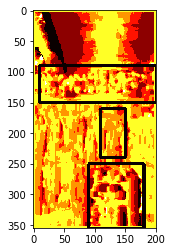

In [41]:
draws = np.copy(thru)
draws= cv2.rectangle(draws, (90,250),(180,355),(0,0,0),3)
draws= cv2.rectangle(draws, (10,90),(200,150),(0,0,0),3)
draws= cv2.rectangle(draws, (110,160),(150,240),(0,0,0),3)
#cv2.imshow('drwa',draws)
plt.imshow(draws, cmap='hot')
plt.show()
plt.imsave('C:/Users/reemasinghal/Desktop/cv_project_images/draws.png', draws, cmap='hot')

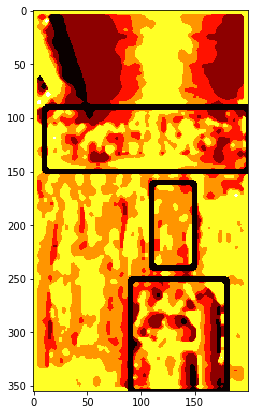

In [42]:
#we apply median filtering to remove salt and pepper noise
draws = draws.astype(np.uint8)
sp_u = cv2.medianBlur(draws,5)

plt.figure(figsize=(7,7))
plt.imshow(sp_u, cmap = 'hot')
plt.show()
plt.imsave("C:/Users/reemasinghal/Desktop/cv_project_images/meadian_filtered_image5.png", sp_u, cmap = 'hot')